In [3]:
from tqdm import tqdm
from ratelimit import limits, sleep_and_retry
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
import pprint
import pickle
import pandas as pd
import numpy as np
import nltk
import seaborn
from nltk.corpus import stopwords

import warnings
import time
import random
import re
from glob import glob
import os
warnings.simplefilter('ignore')


nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Hobin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Hobin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [302]:
from db_helper import *
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
a = ['Information Technology', 'Health Care', 'Consumer Discretionary', 'Communication Services',
     'Financials', 'Industrials', 'Consumer staples', 'Utilities', 'Materials', 'Real Estate', 'Energy']
b = [27.6, 13.44, 12.7, 10.79, 10.34, 8.47, 6.55, 2.73, 2.64, 2.41, 2.33]
c = [71, 62, 61, 26, 66, 73, 33, 28, 28, 31, 26]

a = pd.Series(a)
b = pd.Series(b)
c = pd.Series(c)

sp_gics = pd.concat([a, b, c], axis=1)
sp_gics.columns = ['GICS', 'S&P Weight', 'Count']
#data['agg'] = data['S&P Weight'] * data['Count']
sp_gics

,GICS,S&P Weight,Count
0,Information Technology,27.60,71
1,Health Care,13.44,62
2,Consumer Discretionary,12.70,61
3,Communication Services,10.79,26
4,Financials,10.34,66
5,Industrials,8.47,73
6,Consumer staples,6.55,33
7,Utilities,2.73,28
8,Materials,2.64,28
9,Real Estate,2.41,31


In [4]:
selected_gics = sp_gics.sort_values(
    by='S&P Weight', ascending=False)[:5]['GICS']

In [5]:
selected_gics

0    Information Technology
1               Health Care
2    Consumer Discretionary
3    Communication Services
4                Financials
Name: GICS, dtype: object

In [9]:
data = get_sp500()
selected_data = data.loc[data.GICS.isin(selected_gics)]
selected_data['marketcap'] = selected_data.Symbol.map(
    lambda x: yf.Ticker(x).info['marketCap'])

In [10]:
selected_data.to_csv('./data/selected_gics_data.csv')
selected_data = pd.read_csv(
    './data/selected_gics_data.csv')[['Symbol', 'Security', 'GICS', 'CIK', 'marketcap']]
selected_data.tail()

,Symbol,Security,GICS,CIK,marketcap
286,YUM,Yum! Brands Inc,Consumer Discretionary,1041061,31064694784
287,ZBRA,Zebra Technologies,Information Technology,877212,26703222784
288,ZBH,Zimmer Biomet,Health Care,1136869,33892999168
289,ZION,Zions Bancorp,Financials,109380,8731257856
290,ZTS,Zoetis,Health Care,1555280,73788375040


In [11]:
data_by_gics = {}
for GICS in selected_gics:
    data_by_gics[GICS] = get_cik_by_sector(GICS)

try:
    for key in data_by_gics.keys():
        if len(data_by_gics[key]) <= 30:
            del(data_by_gics[key])
        temp = selected_data[selected_data.GICS ==
                             key][['Symbol', 'marketcap']]
        temp = temp[temp.marketcap >= temp.marketcap.median()]
        data_by_gics[key] = pd.merge(data_by_gics[key], temp)

except:
    for key in data_by_gics.keys():
        if len(data_by_gics[key]) <= 30:
            del(data_by_gics[key])
        temp = selected_data[selected_data.GICS ==
                             key][['Symbol', 'marketcap']]
        temp = temp[temp.marketcap >= temp.marketcap.median()]
        data_by_gics[key] = pd.merge(data_by_gics[key], temp)

In [12]:
sec_api = SecAPI()


def get_sec_data(cik, doc_type, start=0, count=60):
    newest_data = pd.to_datetime('2021-12-12')
    rss_url = 'https://www.sec.gov/cgi-bin/browse-edgar?action=getcompany' \
        '&CIK={}&type={}&start={}&count={}&owner=exclude&output=atom' \
        .format(cik, doc_type, start, count)
    sec_data = sec_api.get(rss_url)
    feed = BeautifulSoup(sec_data.encode('ascii'), 'xml').feed
    entries = [
        (
            entry.content.find('filing-href').getText(),
            entry.content.find('filing-type').getText(),
            entry.content.find('filing-date').getText())
        for entry in feed.find_all('entry', recursive=False)
        if pd.to_datetime(entry.content.find('filing-date').getText()) <= newest_data]

    return entries

In [13]:
sec_data = {}
for sector in data_by_gics:
    sec_data[sector] = {}
    for idx in range(len(data_by_gics[sector])):
        ticker, cik, _ = data_by_gics[sector].iloc[idx, :]
        sec_data[sector][ticker] = get_sec_data(cik, '10-')

----------------------------------

In [14]:
it_sec_data = pd.DataFrame(sec_data)[['Information Technology']].dropna()
hc_sec_data = pd.DataFrame(sec_data)[['Health Care']].dropna()
cd_sec_data = pd.DataFrame(sec_data)[['Consumer Discretionary']].dropna()
fn_sec_data = pd.DataFrame(sec_data)[['Financials']].dropna()

In [341]:
it_sec_data

,Information Technology
AAPL,[(https://www.sec.gov/Archives/edgar/data/3201...
ACN,[(https://www.sec.gov/Archives/edgar/data/1467...
ADBE,[(https://www.sec.gov/Archives/edgar/data/7963...
ADI,[(https://www.sec.gov/Archives/edgar/data/6281...
ADP,[(https://www.sec.gov/Archives/edgar/data/8670...
ADSK,[(https://www.sec.gov/Archives/edgar/data/7693...
AMAT,[(https://www.sec.gov/Archives/edgar/data/6951...
AMD,[(https://www.sec.gov/Archives/edgar/data/2488...
APH,[(https://www.sec.gov/Archives/edgar/data/8203...
AVGO,[(https://www.sec.gov/Archives/edgar/data/1730...


In [217]:
def num_split(ls, num=5):
    data, temp = [], []
    for idx in range(len(ls)):
        temp.append(ls[idx])
        if len(temp) == num:
            data.append(temp)
            temp = []
        if idx == len(ls)-1 and len(temp) > 0:
            data.append(temp)
    return data


def clean_text(raw_text):
    four_only = re.sub(r'\b\w{1,3}\b', '', raw_text)
    letters_only = re.sub("[^a-zA-Z]", " ", four_only)
    text = letters_only.split()
    removed = [
        w for w in text if w not in nltk.corpus.stopwords.words('english')]
    return ' '.join(removed)


def get_mda(raw_text, file_type):
    try:
        text = BeautifulSoup(raw_text, 'html.parser').get_text().lower().replace(
            '\xa0', ' ').replace('\x92', ' ').replace('\x93', ' ').replace('\x94', ' ').replace('\u200b', ' ')
    except:
        text = BeautifulSoup(raw_text, 'html5lib').get_text().lower().replace(
            '\xa0', ' ').replace('\x92', ' ').replace('\x93', ' ').replace('\x94', ' ').replace('\u200b', ' ')
    text = re.sub('\s+', ' ', text)
    text = re.sub("(\'|’)", '', text)
    # item 2/7로 시작하는 mda를 골라내기

    if re.search('\billumina\b', text):
        if '20200211' in text or '20200501' in text or '20200807' in text or '20201030' in text or '20210217' in text:
            keyword = 'our discussion of our results of operations'
            text = text[re.search(keyword, text).end():]
            if file_type == '10-Q':
                except_keyword = 'we design our internal controls to provide reasonable assurance'
                text = text[:re.search(except_keyword, text).start()]
                return text
            else:
                except_keyword = 'we have audited the accompanying consolidated balance sheets of Illumin'.lower()
                text = text[:re.search(except_keyword, text).start()]
                return text

    if 'intc' in text and 'paj.intc' not in text:
        try:
            keyword = '(table of contents)\s*management\s*s discussion and analysis'
            text1 = text[re.search(keyword, text).end():]
            if file_type == '10-Q':
                except_keyword = '(other\s*key\s*information|\d\W{0,1}\s*quantitative and qualitative disclosure)'
                text = text1[:re.search(except_keyword, text1).start()]
                return text
            else:
                except_keyword = '(other\s*key\s*information|\d\W{0,1}\s*quantitative and qualitative disclosure)'
                text = text1[:re.search(except_keyword, text1).start()]
                return text
        except:
            try:
                keyword = '\s*\d\s*\W{0,1}\s*management\s*s discussion and analysis\s*of financial condition and results of operations{0,1}' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis\s*of financial condition and results of operations{0,1}'
                except_keyword = '(item\s*3\s*\W{0,1}\s*\w+|item\s*4\s*\W{0,1}\s*\w+)' if file_type == '10-Q' else 'item\s*7a\s*\W{0,1}\s*quantitative and qualitative disclosure'
                text = text[re.search(keyword, text).end():]
                text = text[re.search(keyword, text).end():]
                text = text[:re.search(except_keyword, text).start()]
                return text
            except:
                keyword = '\s*\d\s*\W{0,1}\s*management\s*s discussion and analysis\s*of financial condition and results of operations{0,1}' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis\s*of financial condition and results of operations{0,1}'
                except_keyword = '(item\s*3\s*\W{0,1}\s*\w+|item\s*4\s*\W{0,1}\s*\w+)' if file_type == '10-Q' else 'item\s*7a\s*\W{0,1}\s*quantitative and qualitative disclosure'
                text = text[:re.search(except_keyword, text).start()]
                return text

    keyword = '\s*\d\s*\W{0,1}\s*management\s*s discussion and analysis\s*of financial condition and results of operations{0,1}' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis\s*of financial condition and results of operations{0,1}'
    # 2개 이상있다는 것은 table of contents에서 잡아내는 것
    if len(re.findall(keyword, text)) > 1:
        # table of contents는 거르고, mda이하를 잡아낸다.
        text1 = text[re.search(keyword, text).end():]
        text2 = text1[re.search(keyword, text1).end():]
        text = text2
        if 'item' in text2[:30]:
            text = text1
            if 'item' in text[:30]:
                try:
                    try:
                        keyword = 'table\s*of\s*contents\s*(item\s*2\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1})' if file_type == '10-Q' else 'table\s*of\s*contents\s*(item\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1})'
                        text = text[re.search(keyword, text).end():]
                    except:
                        keyword = 'item\s*2\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}\s*the following' if file_type == '10-Q' else 'item\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}\s*the following'
                        text = text[re.search(keyword, text).end():]
                except:
                    try:
                        keyword = 'item\s*2\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}\s*the following' if file_type == '10-Q' else 'item\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}\s*the following'
                        text = text2[re.search(keyword, text2).end():]
                    except:
                        keyword = 'item\s*2\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}' if file_type == '10-Q' else 'item\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}'
                        text = text2[re.search(keyword, text2).end():]
    # 아예 mda가 없는 경우
    elif len(re.findall('discussion and analysis of financial condition', text)) == 0:
        keyword = 'discussion and analysis\s*of results of operations{0,1} and financial condition\s*organization and business segments'
        if re.search(keyword, text):
            text = text[re.search(keyword, text).end():]
        else:
            try:
                keyword = '\s*2\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}\s*results of operations' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}\s*results of operations'
                if re.search(keyword, text):
                    text = text[re.search(keyword, text).end():]
                else:
                    keyword = '\s*2\s*\W{0,1}\s*management\s*s discussion and analysis\s*of financial condition and results of operations{0,1}\s*operating results' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of financial condition and results of operations{0,1}\s*operating results'
                    text = text[re.search(keyword, text).end():]
            except:
                try:
                    keyword = '\s*2\s*\W{0,1}\s*management\s*s discussion and analysis\s*of results of operations{0,1} and financial condition\s*results of operations' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of results of operations{0,1} and financial condition\s*results of operations'
                    if re.search(keyword, text):
                        text = text[re.search(keyword, text).end():]
                    else:
                        keyword = '\s*2\s*\W{0,1}\s*management\s*s discussion and analysis\s*of results of operations{0,1} and financial condition\s*operating results' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of results of operations{0,1} and financial condition\s*operating results'
                        text = text[re.search(keyword, text).end():]
                except:
                    try:
                        keyword = '\s*2\s*\W{0,1}\s*management\s*s discussion and analysis\s*of results of operations{0,1} and financial condition' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis\s*of results of operations{0,1} and financial condition'
                        text = text[re.search(keyword, text).end():]
                        text = text[re.search(keyword, text).end():]
                    except:
                        return text
                        keyword = '\s*2\s*\W{0,1}\s*management\s*s discussion and analysis\s*of\s*financial condition\s*and results of operations{0,1}' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis\s*of\s*financial condition\s*and results of operations{0,1}'
                        text = text[re.search(keyword, text).end():]
                        text = text[re.search(keyword, text).end():]

    # table of contents가 없는 경우
    else:
        # 바로 mda 이하 잡아내기
        try:
            text = text[re.search(keyword, text).end():]
        # table of contents도 없는데 item으로 시작하지도 않는 경우
        except:
            try:
                text = text[re.search(
                    'this discussion and analysis should be read in conjunction with the md', text).end():]
            except:
                try:
                    keyword = 'discussion and analysis of results of operations{0,1} and financial condition\s*organization and business segments'
                    text = text[re.search(keyword, text).end():]
                except:
                    keyword = '\s*2\s*\W{0,1}\s*management\s*s discussion and analysis of results of operations and{0,1} financial condition' if file_type == '10-Q' else '\s*7\s*\W{0,1}\s*management\s*s discussion and analysis of results of operations{0,1} and financial condition'
                    if len(re.findall(keyword, text)) == 1:
                        text = text[re.search(keyword, text).end():]
                    else:
                        text1 = text[re.search(keyword, text).end():]
                        text2 = text1[re.search(keyword, text1).end():]
                        if 'item' in text2[:20]:
                            text = text2[re.search(keyword, text2).end():]

    # return text
    # mda만 골라내는 작업
    # item 7a인 경우

    try:
        # item ~~인 경우
        try:
            except_keyword = '(item\s*3\s*\W{0,1}\s*\w+|item\s*4\s*\W{0,1}\s*\w+)' if file_type == '10-Q' else 'item\s*7a\s*\W{0,1}\s*quantitative and qualitative disclosure'
            text = clean_text(
                text[:re.search(except_keyword, text).start()])
            return text
        # item이 아닌 경우
        except:
            try:
                # non-gaap가 뜬금없이 다음에 오는 경우
                if 'Explanation and Reconciliation of Non'.lower() in text:
                    except_keyword = 'that are not calculated in accordance with gaap'
                    text = clean_text(
                        text[:re.search(except_keyword, text).start()])
                    return text
                # 그게 아닌 경우 (정상)
                else:
                    except_keyword = 'quantitative and qualitative disclosure'
                    text = clean_text(
                        text[:re.search(except_keyword, text).start()])
                    return text
            except:
                except_keyword = 'qualitative and quantitative disclosure'
                text = clean_text(
                    text[:re.search(except_keyword, text).start()])
                return text

    # item 8인 경우 (정말 혹시 몰라서)
    except:
        try:
            except_keyword = '(item\s*3\s*\W{0,1}\s*\w+|item\s*4\s*\W{0,1}\s*\w+)' if file_type == '10-Q' else 'item\s*8\s*\W{0,1}\s*quantitative and qualitative disclosure'
            text = clean_text(
                text[:re.search(except_keyword, text).start()])
            return text
        except:
            if 'Explanation and Reconciliation of Non'.lower() in text:
                except_keyword = 'that are not calculated in accordance with gaap'
                text = clean_text(
                    text[:re.search(except_keyword, text).start()])
                return text
            else:
                except_keyword = 'quantitative and qualitative disclosure'
                text = clean_text(
                    text[:re.search(except_keyword, text).start()])
                return text


def raw_filings(sector):
    data = pd.DataFrame(sec_data)[[sector]].dropna()
    #indices = num_split(data.index.values, 5)
    indices = data.index.values[28:]
    print(str(len(indices))+'csv will be generated')
    count = 0
    for index in indices:
        count += 1
        #temp = data.loc[index]
        result = pd.DataFrame(
            columns=['ticker', 'date', 'url', 'type', 'text'])
        ticker, date, url, tp, text = [], [], [], [], []

        # for idx in temp.index.values:
        # for index_url, file_type, file_date in tqdm(temp.loc[idx].values[0], desc='Downloading {} Fillings'.format(idx), unit='filling'):
        for index_url, file_type, file_date in tqdm(data.loc[index].values[0], desc='Downloading {} Fillings'.format(index), unit='filling'):
            try:
                if file_type == '10-K' or file_type == '10-Q':
                    file_url = index_url.replace(
                        '-index.htm', '.txt').replace('.txtl', '.txt')
                    ticker.append(index)
                    date.append(file_date)
                    url.append(file_url)
                    tp.append(file_type)
                    text.append(get_mda(sec_api.get(file_url), file_type))

            except:
                print(file_type, file_url)
                return

        time.sleep(2)

        result['ticker'] = ticker
        result['date'] = date
        result['url'] = url
        result['type'] = tp
        result['text'] = text
        result.to_csv('./data/filing data/{}/{}'.format(sector,
                                                        sector+'_'+index+'.csv'))
        print("{}th csv generated! {} left".format(count, len(indices)-count))

        del(result)
        # del(temp)
        del(ticker)
        del(date)
        del(url)
        del(tp)
        del(text)
    return

In [219]:
raw_filings('Information Technology')

10csv will be generated


1th csv generated! 9 left


2th csv generated! 8 left


3th csv generated! 7 left


4th csv generated! 6 left


5th csv generated! 5 left


6th csv generated! 4 left


7th csv generated! 3 left


8th csv generated! 2 left


9th csv generated! 1 left


10th csv generated! 0 left


-----------------------

In [225]:
sentiments = ['negative', 'positive', 'uncertainty']

sentiment_df = pd.read_csv(os.path.join(
    'data', 'loughran_mcdonald', 'LoughranMcDonald_MasterDictionary_2018.csv'))
sentiment_df.columns = [column.lower() for column in sentiment_df.columns]
sentiment_df = sentiment_df[sentiments + ['word']]
sentiment_df[sentiments] = sentiment_df[sentiments].astype(bool)
sentiment_df = sentiment_df[(sentiment_df[sentiments]).any(1)]
sentiment_df['word'] = sentiment_df['word'].map(str.lower)

In [340]:
sentiment_df[sentiment_df.positive == True].word

125            able
336       abundance
338        abundant
438       acclaimed
477      accomplish
            ...    
85238           win
85360        winner
85361       winners
85362       winning
85897        worthy
Name: word, Length: 354, dtype: object

In [227]:
#sentiment_df['word'] = lemmatize_words(sentiment_df['word'].str.lower())
#sentiment_df = sentiment_df.drop_duplicates('word')

In [424]:
hc_filing_data = pd.read_csv('./data/filing data/Health Care/Health Care1.csv',
                             usecols=['ticker', 'date', 'type', 'text'])
for data in glob('./data/filing data/Health Care/Health Care_*.csv'):
    temp = pd.read_csv(data, usecols=['ticker','date','type','text'])
    hc_filing_data = pd.concat([hc_filing_data, temp])
hc_filing_data = hc_filing_data.reset_index(drop=True)
hc_filing_data = hc_filing_data.set_index('date')
hc_filing_data.index = pd.to_datetime(hc_filing_data.index)
hc_filing_data = hc_filing_data.sort_values(by='date')
hc_filing_data = hc_filing_data.dropna()

In [4]:
it_filing_data = pd.read_csv('./data/filing data/Information Technology/Information Technology_AAPL.csv',
                             usecols=['ticker', 'date', 'type', 'text'])
for data in glob('./data/filing data/Information Technology/Information Technology_*.csv')[1:]:
    temp = pd.read_csv(data, usecols=['ticker','date','type','text'])
    it_filing_data = pd.concat([it_filing_data, temp])
it_filing_data = it_filing_data.reset_index(drop=True)
it_filing_data = it_filing_data.set_index('date')
it_filing_data.index = pd.to_datetime(it_filing_data.index)
it_filing_data = it_filing_data.sort_values(by='date')
it_filing_data = it_filing_data.dropna()

In [20]:
data = ''
for report in it_filing_data.text.values:
    first = ' '+report
    data += first

In [22]:
words = word_tokenize(data)

In [24]:
freqwords = nltk.FreqDist(words)

In [ ]:
freqworeds

In [28]:
dict(freqwords).values()

dict_values([3992, 9151, 5925, 49410, 8555, 30352, 34225, 483, 50752, 750, 586, 1145, 4783, 34285, 20665, 63230, 57772, 5766, 2631, 1902, 39530, 992, 14988, 17952, 3030, 994, 69318, 33571, 57700, 1415, 1606, 21302, 30105, 41516, 20179, 1567, 6190, 9234, 8899, 16840, 8305, 42794, 74842, 9187, 7928, 821, 331, 2437, 12387, 2215, 3041, 587, 368, 239, 1142, 14619, 5071, 1418, 25446, 748, 205, 5468, 152, 2504, 1538, 1071, 118, 9161, 8212, 12339, 7263, 11559, 981, 187, 8057, 16, 1504, 777, 1177, 695, 3843, 10101, 23322, 3083, 202, 11655, 4403, 916, 1827, 1735, 23418, 25676, 2274, 22165, 15624, 18551, 7504, 725, 415, 455, 1426, 9224, 13341, 11890, 3951, 11720, 6149, 10157, 3546, 532, 748, 10036, 1443, 11153, 21312, 5764, 9077, 4710, 2325, 7836, 7248, 645, 135, 4033, 508, 275, 89, 591, 5518, 7689, 19106, 21770, 12829, 11199, 20049, 21546, 1298, 5885, 87, 12619, 10937, 42730, 46193, 8684, 2610, 1392, 5295, 20784, 1769, 1870, 228, 725, 4459, 54, 906, 8903, 2102, 14673, 5776, 758, 750, 6784, 8099,

In [10]:
import nltk
from nltk import word_tokenize

# TFIDF
using the sentiment word lists, let's generate sentiment TFIDF from the 10-k documents. Implement `get_tfidf` to generate TFIDF from each document, using sentiment words as the terms. You can ignore words that are not in `sentiment_words`.

In [391]:
from sklearn.feature_extraction.text import TfidfVectorizer


def get_tfidf(sentiment_vocab, docs):
    vector = TfidfVectorizer(vocabulary=sentiment_vocab, sublinear_tf= True, min_df=2)
    result = vector.fit_transform(docs).toarray()

    return result

Using the `get_tfidf` function, let's generate the TFIDF values for all the documents.

In [392]:
sentiment_tfidf_hc = {}

for ticker in hc_filing_data.ticker.unique():
    docs = list(hc_filing_data[hc_filing_data.ticker == ticker].text)
    
    sentiment_tfidf_hc[ticker] = {
        sentiment : get_tfidf(
        sentiment_df[sentiment_df[sentiment]]['word'], docs)
    for sentiment in sentiments}


In [393]:
sentiment_tfidf_it = {}

for ticker in it_filing_data.ticker.unique():
    docs = list(it_filing_data[it_filing_data.ticker == ticker].text)
    
    sentiment_tfidf_it[ticker] = {
        sentiment : get_tfidf(
        sentiment_df[sentiment_df[sentiment]]['word'], docs)
    for sentiment in sentiments}


# 코사인

In [394]:
from sklearn.metrics.pairwise import cosine_similarity


def get_cosine_similarity(tfidf_matrix):
    cos_similarity = cosine_similarity(tfidf_matrix[0:], tfidf_matrix[1:])

    return cos_similarity[0].tolist()

In [395]:
cosine_similarities_hc = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_hc.items()}

cosine_similarities_it = {
    ticker: {
        sentiment_name: get_cosine_similarity(sentiment_values)
        for sentiment_name, sentiment_values in ten_k_sentiments.items()}
    for ticker, ten_k_sentiments in sentiment_tfidf_it.items()}

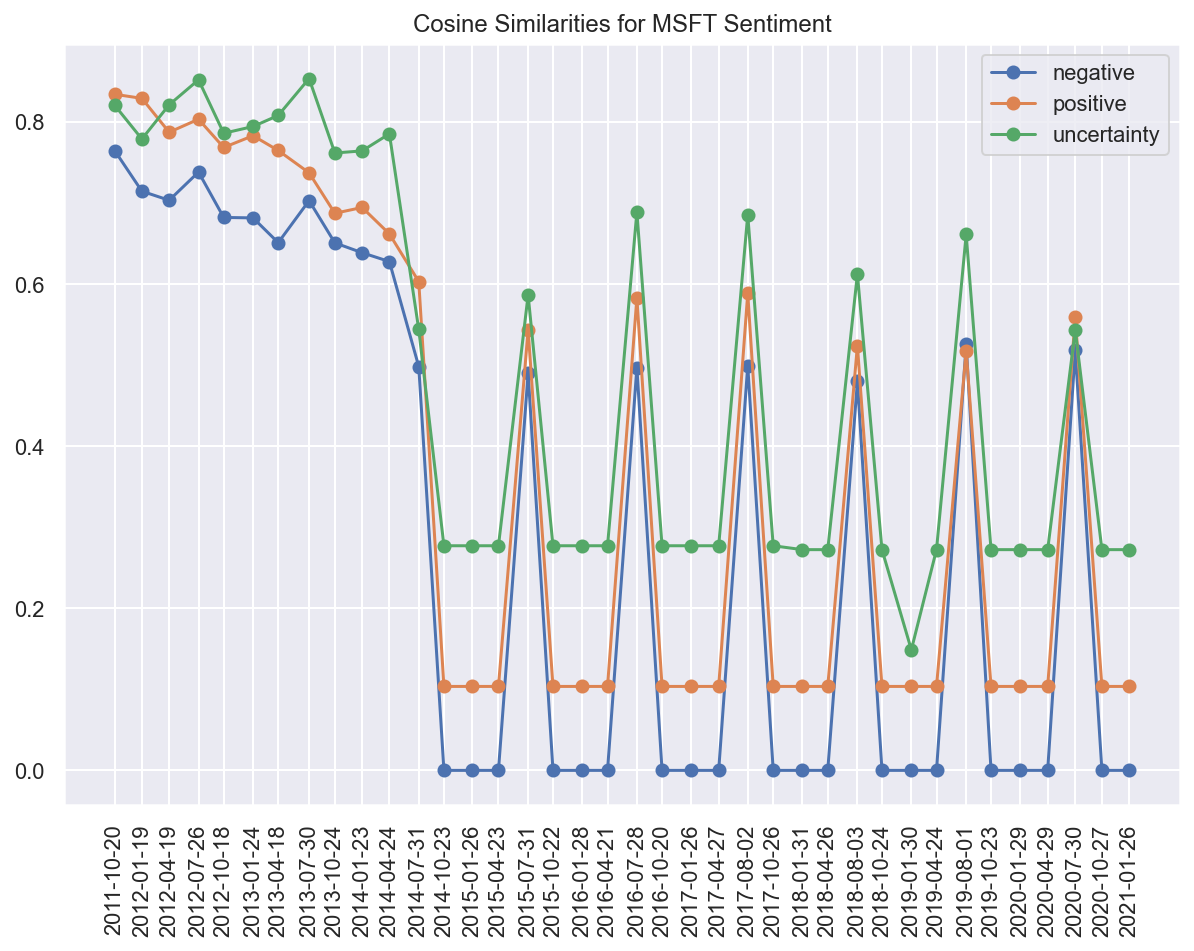

In [396]:
plot_similarities(
    [cosine_similarities_it['MSFT'][sentiment] for sentiment in sentiments],
    
    it_filing_data[it_filing_data.ticker=='MSFT'].index.values[1:],
    'Cosine Similarities for {} Sentiment'.format('MSFT'),
    sentiments)

In [350]:
get_etf_code()

,Item,Code,Day_URL
0,TIGER 200 IT,139260,https://finance.naver.com/item/sise_day.nhn?co...
1,TIGER 헬스케어,143860,https://finance.naver.com/item/sise_day.nhn?co...
2,TIGER 200 금융,139270,https://finance.naver.com/item/sise_day.nhn?co...
3,TIGER 증권,157500,https://finance.naver.com/item/sise_day.nhn?co...
4,TIGER 200 생활소비재,227560,https://finance.naver.com/item/sise_day.nhn?co...


In [353]:
tiger_it = get_etf_data(139260)
tiger_it.tail()

,종가,전일비,시가,고가,저가,거래량
Date,,,,,,
2011-04-22,14355,300,14400,14405,14250,47337
2011-04-21,14655,440,14440,14655,14350,76628
2011-04-20,14215,585,13880,14245,13860,17471
2011-04-19,13630,115,13420,13630,13420,8522
2011-04-18,13515,45,13645,13645,13515,5024


In [352]:
tiger_hc = get_etf_data(143860)
tiger_hc.tail()

,종가,전일비,시가,고가,저가,거래량
Date,,,,,,
2011-08-03,14650,0,14285,14650,14190,3888
2011-08-02,14650,165,14815,14845,14570,6792
2011-08-01,14815,45,14860,14865,14655,4290
2011-07-29,14770,110,14650,14940,14650,6329
2011-07-28,14660,155,14390,14675,14225,4767


In [358]:
tiger_it_return = tiger_it['종가'].pct_change()
tiger_it_return

Date
2021-02-26         NaN
2021-02-25    0.038633
2021-02-24   -0.038792
2021-02-23    0.026692
2021-02-22    0.014181
                ...   
2011-04-22    0.005957
2011-04-21    0.020899
2011-04-20   -0.030024
2011-04-19   -0.041154
2011-04-18   -0.008437
Name: 종가, Length: 2430, dtype: float64

In [357]:
tiger_hc_return = tiger_hc['종가'].pct_change()
tiger_hc_return

Date
2021-02-26         NaN
2021-02-25    0.022308
2021-02-24   -0.051839
2021-02-23    0.035748
2021-02-22    0.033160
                ...   
2011-08-03    0.008259
2011-08-02    0.000000
2011-08-01    0.011263
2011-07-29   -0.003037
2011-07-28   -0.007448
Name: 종가, Length: 2360, dtype: float64

In [505]:
tiger_it_close = tiger_it['종가']

positive 1/3 
uncertainty 1/3
negative 1/3

필요한 것

- date별 sentiment가 나올 때마다 순위가 갱신되는 알고리즘
- 순위 내 stock의 marketcap에 해당하는 weight를 부여하여 수익률을 가중평균
- 그 수익률과 etf의 수익률 / 종가의 움직임을 비교

In [456]:
it_positive = []
it_uncertainty = []
it_negative = []
for ticker in it_filing_data.ticker.unique():
    it_positive.append(pd.Series(get_cosine_similarity(sentiment_tfidf_it[ticker]['positive']), index=it_filing_data[it_filing_data.ticker==ticker].index[1:],name=ticker))
    it_uncertainty.append(pd.Series(get_cosine_similarity(sentiment_tfidf_it[ticker]['uncertainty']), index=it_filing_data[it_filing_data.ticker==ticker].index[1:],name=ticker))
    it_negative.append(pd.Series(get_cosine_similarity(sentiment_tfidf_it[ticker]['negative']), index=it_filing_data[it_filing_data.ticker==ticker].index[1:],name=ticker))

In [457]:
hc_positive = []
hc_uncertainty = []
hc_negative = []
for ticker in hc_filing_data.ticker.unique():
    hc_positive.append(pd.Series(get_cosine_similarity(sentiment_tfidf_hc[ticker]['positive']), index=hc_filing_data[hc_filing_data.ticker==ticker].index[1:], name=ticker))
    hc_uncertainty.append(pd.Series(get_cosine_similarity(sentiment_tfidf_hc[ticker]['uncertainty']), index=hc_filing_data[hc_filing_data.ticker==ticker].index[1:], name=ticker))
    hc_negative.append(pd.Series(get_cosine_similarity(sentiment_tfidf_hc[ticker]['negative']), index=hc_filing_data[hc_filing_data.ticker==ticker].index[1:],name=ticker))

In [ ]:
hc_positive = pd.DataFrame(hc_positive).T
hc_negative = pd.DataFrame(hc_negative).T
hc_uncertainty = pd.DataFrame(hc_uncertainty).T

In [461]:
it_positive = pd.DataFrame(it_positive).T
it_negative = pd.DataFrame(it_negative).T
it_uncertainty = pd.DataFrame(it_uncertainty).T

In [462]:
it_uncertainty

,PAYX,ORCL,ADBE,QCOM,AAPL,TEL,IBM,KLAC,LRCX,FISV,...,MCHP,AMAT,SNPS,HPQ,GPN,AMD,MU,NOW,PYPL,AVGO
date,,,,,,,,,,,,,,,,,,,,,
2011-06-28,NaN,0.596251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-29,NaN,NaN,0.987823,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-15,0.745628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-20,NaN,NaN,NaN,0.961324,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-22,NaN,NaN,NaN,NaN,NaN,0.95669,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.50454,NaN,0.436807,NaN,NaN,NaN,NaN,NaN
2021-02-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-02-23,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [475]:
it_uncertainty.max(axis=1)

date
2011-06-28    0.596251
2011-06-29    0.987823
2011-07-15    0.745628
2011-07-20    1.000000
2011-07-22    0.956690
                ...   
2021-02-19    0.504540
2021-02-22    0.349754
2021-02-23    0.584431
2021-02-25    0.643494
2021-02-26    0.378847
Length: 908, dtype: float64

In [539]:
sent = it_negative.max(axis=1)

In [540]:
test = pd.concat([tiger_it_return, sent],axis=1)

In [541]:
test.columns = ['ETF','sentiment']

In [542]:
etf_mean = test.ETF.mean()
etf_std = test.ETF.std()
test.ETF = (test.ETF - etf_mean) /etf_std

In [543]:
sent_mean = test.sentiment.mean()
sent_std = test.sentiment.std()
test.sentiment = (test.sentiment - sent_mean) /sent_std

In [544]:
test = test.fillna(method='bfill')
test = test.fillna(method='ffill')

<AxesSubplot:>

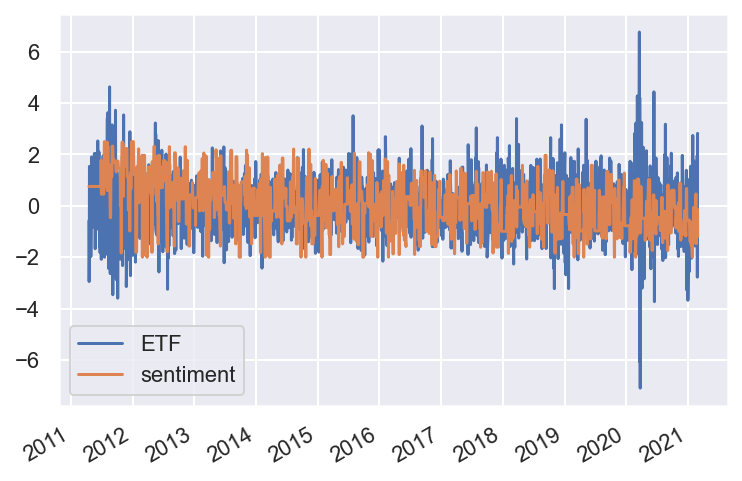

In [545]:
test.plot()

In [546]:
from statsmodels.tsa.stattools import coint

X = test.ETF
Y = test.sentiment

score, pvalue, _ = coint(X,Y)

In [547]:
pvalue

0.0

In [548]:
X.corr(Y)

0.026632066352724762